In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from lesson_functions import *
import glob
import time

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
def train_test_split_with_GTI(X, y, group_id, test_size, random_state):
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    
    for c_id in np.unique(group_id):
        X_group = X[group_id == c_id,:]
        y_group = y[group_id == c_id]
        if c_id ==0:
            # If this is KTTI data then, split it 
            X_train, X_test, y_train, y_test = train_test_split(
                X_group, y_group, test_size=0.2, random_state=0, stratify=y_group)
        else:         
            np.random.seed(c_id + random_state)
            test_index = np.mod(np.random.randint(0, X_group.shape[0]) + np.arange(0, int(X_group.shape[0] * test_size)),
                                 X_group.shape[0])
            train_index = list(set(range(0, X_group.shape[0])).difference(set(test_index)))
            X_train = X_group[train_index,:]
            X_test = X_group[test_index,:]
            y_train = y_group[train_index]
            y_test = y_group[test_index]
            
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)
    return np.concatenate(X_train_list, axis=0), np.concatenate(X_test_list, axis=0), np.concatenate(y_train_list), np.concatenate(y_test_list)

In [5]:
# create vehicle img list. We mark whether the data belongs to a certain GTI data directory.

vehicle_GTI_dirs = ['./data/vehicles/GTI_Far/', './data/vehicles/GTI_Left/', './data/vehicles/GTI_MiddleClose/', './data/vehicles/GTI_Right/']
vehicle_img_list = []
GTI_group_ids = []
cgroup_id = 1
for GTI_dir in vehicle_GTI_dirs:
    GTI_current_list = glob.glob(GTI_dir + '*.png')  
    vehicle_img_list = vehicle_img_list + GTI_current_list   
    GTI_group_ids = GTI_group_ids + [np.ones(len(GTI_current_list))*cgroup_id]
    cgroup_id += 1
KTTI_list = glob.glob('./data/vehicles/KITTI_extracted/*.png')
vehicle_img_list = vehicle_img_list+ KTTI_list
vehicle_group_id = np.concatenate(GTI_group_ids + [np.zeros(len(KTTI_list))])

# create non vehicle img list and group ids for non-vehicle data
non_vehicle_img_list = glob.glob('./data/non-vehicles/GTI/*.png') + glob.glob('./data/non-vehicles/Extras/*.png')
non_vehicle_group_id = np.zeros(len(non_vehicle_img_list))

# load all images
vehicle_images =  [cv2_readRGB(w) for w in vehicle_img_list]
non_vehicle_images =  [cv2_readRGB(w) for w in non_vehicle_img_list]
group_id = np.concatenate([vehicle_group_id, non_vehicle_group_id]).astype(int)

In [6]:
from sklearn.utils import shuffle
def obtain_fold_group(group_id,K):
    # divide data into K folds and return the fold index each sample belongs to
    test_fold_index = np.zeros_like(group_id)
    for c_id in np.unique(group_id):
        n_sample_in_group = np.sum(group_id == c_id)
        if c_id ==0:
            test_fold_index[group_id == c_id] = shuffle(np.floor_divide(np.arange(0, n_sample_in_group), np.ceil(n_sample_in_group/K)),random_state=0) 
        else:
            test_fold_index[group_id == c_id] = np.floor_divide(np.arange(0, n_sample_in_group), np.ceil(n_sample_in_group/K))
    return test_fold_index.astype(int)            

In [7]:
fold_indices = obtain_fold_group(group_id, 5)

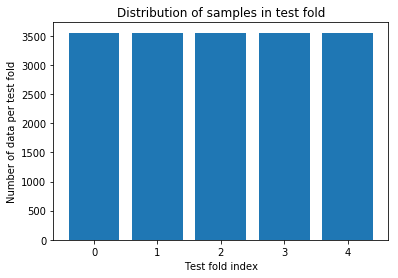

In [8]:
from scipy import stats
test_fold_dist = stats.itemfreq(fold_indices)
plt.bar(test_fold_dist[:,0], test_fold_dist[:,1])
plt.title('Distribution of samples in test fold')
plt.xlabel('Test fold index')
plt.ylabel('Number of data per test fold')
plt.savefig('./output_images/test_fold_distribution.png')

In [11]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
color_space = 'YUV'
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

# Other feature parameter

In [ ]:
result = {}

for hist_bins in [8, 16, 32]:
    for spatial_size in [(16,16), (32,32)]:
        print((hist_bins, spatial_size))
        car_features = extract_features(vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train_validate = scaled_X[fold_indices!=0,:]
        y_train_validate = y[fold_indices!=0]
        fold_train_validate = fold_indices[fold_indices!=0]        

        clf = LinearSVC()
        
        # 
        t=time.time()
        train_scores, test_scores = validation_curve(clf, X_train_validate, y_train_validate,
                                                     'C', np.array([1.0]),
                                                     cv= PredefinedSplit(fold_train_validate), n_jobs=5)
        #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
        # Check the training time for the SVC                        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train classifier...')
        # Check the score of the SVC
        print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
        print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
        # Check the prediction time for a single sample
        result[(hist_bins, spatial_size)] = {'train': train_scores,
                                              'test': test_scores,
                                              'scaler': X_scaler}
result_l2 = result        

(8, (16, 16))


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/pool.py", line 366, in _handle_workers
    pool._maintain_pool()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/pool.py", line 240, in _maintain_pool
    self._repopulate_pool()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    

In [ ]:
import pandas as pd
result_df_list = []
for key, val in result.items():
    result_df_list.append(pd.DataFrame({'train_accuracy': val['train'].mean(), 'train_std': val['train'].std(), 'test_accuracy': val['test'].mean(),
                                        'test_std': val['test'].std()}, index=[key]))
                 
    
result_df = pd.concat(result_df_list, axis=0)

In [ ]:
result_df.sort_values('test_accuracy', ascending=False)

We observe that the top channels with best test accuracy is luminance Y in YUV/YCrCb color space. Other top results include L in LUV color space and V in HSV color space, of which both are closely related to Y, and RGB channels. We also observe that the other two channels in YUV / LUV has significantly worse performance. This all supports using Y channel for vehicle recognition. 

## Examine Incorrectly Classified Image

In [ ]:
result = {}
car_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train_validate = scaled_X[fold_indices!=0,:]
y_train_validate = y[fold_indices!=0]
fold_train_validate = fold_indices[fold_indices!=0]        

clf = LinearSVC()

# 
t=time.time()
predicted_label = cross_val_predict(clf, X_train_validate, y_train_validate,\
                                    cv= PredefinedSplit(fold_train_validate), n_jobs=4)
#X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
# Check the training time for the SVC                        
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train classifier...')
# Check the score of the SVC
print('Test Accuracy of Classifier = ', round(np.mean(predicted_label==y_train_validate), 4))
# Check the prediction time for a single sample
result[(hist_bins, spatial_size)] = {'train': train_scores,
                                      'test': test_scores,
                                      'scaler': X_scaler}
